In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import LancasterStemmer


In [2]:
if not nltk.download('stopwords'):
    nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yeqinghua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv('/Users/yeqinghua/Documents/Fake-News-Detection/data/train.csv')
data.shape

(20800, 5)

In [4]:
data.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

In [5]:
data.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
data = data.fillna('')

In [7]:
data['article'] = data['title'] + data['author']

In [8]:
data.drop(columns=['id'], inplace=True)

In [9]:
data['article'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - BreitbartDaniel J. Flynn'

In [10]:
# X = data.drop(columns='label', axis=1)
# Y = data['label']

In [11]:
ps = PorterStemmer()
ls = LancasterStemmer()


In [12]:
# stemmed_word = re.sub('[`~!@#$%^&*()\\]\\[+={}/|:;\"\'<>,.?-_]', X)
def perform_stemming(content):
    remove_special_char = re.sub('[^a-zA-Z]',' ', content)
    string_to_lower = remove_special_char.lower().split()
    #string_split = string_to_lower.split()
    remove_word = [word for word in string_to_lower if not word in stopwords.words('english')]
    stem = [ps.stem(word) for word in remove_word]
    return stem

In [13]:
data['article'] = data['article'].apply(perform_stemming)

In [14]:
#data = perform_stemming_test(data,['article'])

In [15]:
data['article']

0        [hous, dem, aid, even, see, comey, letter, jas...
1        [flynn, hillari, clinton, big, woman, campu, b...
2             [truth, might, get, firedconsortiumnew, com]
3        [civilian, kill, singl, us, airstrik, identifi...
4        [iranian, woman, jail, fiction, unpublish, sto...
                               ...                        
20795    [rapper, trump, poster, child, white, supremac...
20796    [n, f, l, playoff, schedul, matchup, odd, new,...
20797    [maci, said, receiv, takeov, approach, hudson,...
20798    [nato, russia, hold, parallel, exercis, balkan...
20799                       [keep, f, alivedavid, swanson]
Name: article, Length: 20800, dtype: object

In [16]:
# def vectorize_data(data):
#     vectorizer = CountVectorizer()
#     bag_of_words = CountVectorizer(max_features=5000, ngram_range=(1, 5))
#     bag_of_words.fit(data)
#     return features

In [17]:
X = data['article'].map(' '.join)
y = data['label']

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [30]:
X_train.shape

(4160,)

In [31]:
y_test.shape

(16640,)

In [ ]:
def vectorize_data(vectorizer, X_train, X_test):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [33]:
X_train.shape

(4160, 9612)

In [34]:
X_test.shape

(16640, 9612)

In [37]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
reg = LR.fit(X_train, y_train)
reg_pred = reg.predict(X_test)

In [38]:
from sklearn import metrics

print("Logistic Regression model accuracy(in %):", 
metrics.accuracy_score(y_test, reg_pred)*100)

Logistic Regression model accuracy(in %): 95.90745192307692


In [48]:
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors = 2)
 
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
 
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, knn_pred))
 
print(classification_report(y_test, knn_pred))

[[2462 5837]
 [  33 8308]]
              precision    recall  f1-score   support

           0       0.99      0.30      0.46      8299
           1       0.59      1.00      0.74      8341

    accuracy                           0.65     16640
   macro avg       0.79      0.65      0.60     16640
weighted avg       0.79      0.65      0.60     16640



Text(0, 0.5, 'Error Rate')

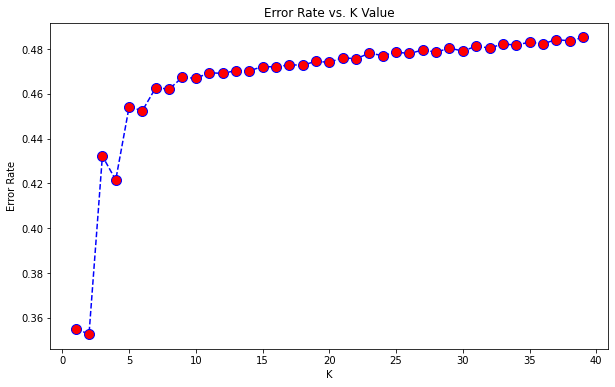

In [46]:
error_rate = []
 
for i in range(1, 40):
     
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
 
plt.figure(figsize =(10, 6))
plt.plot(range(1, 40), error_rate, color ='blue',
                linestyle ='dashed', marker ='o',
         markerfacecolor ='red', markersize = 10)
 
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [56]:
from sklearn.ensemble import RandomForestRegressor
 
rf = RandomForestRegressor(n_estimators = 100, random_state = 0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest model accuracy(in %):", 
metrics.accuracy_score(y_test, rf_pred)*100)

In [ ]:
X_grid = np.arrange(min(X_train), max(X_train), 0.01)
 
# reshape for reshaping the data into a len(X_grid)*1 array,
# i.e. to make a column out of the X_grid value                 
X_grid = X_grid.reshape((len(X_grid), 1))
 
# Scatter plot for original data
plt.scatter(X_train, y_train, color = 'blue') 
 
# plot predicted data
plt.plot(X_grid, rf.predict(X_grid),
         color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


In [51]:
def model(model,X_train, y_train, y_test):
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    #print("model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)
    print(classification_report(y_test, y_pred))

In [55]:
knn = KNeighborsClassifier(n_neighbors = 10)
model(knn, X_train, y_train, y_test)

              precision    recall  f1-score   support

           0       0.99      0.06      0.12      8299
           1       0.52      1.00      0.68      8341

    accuracy                           0.53     16640
   macro avg       0.75      0.53      0.40     16640
weighted avg       0.75      0.53      0.40     16640



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
 
knn = KNeighborsClassifier(n_neighbors = 2)
model(knn)
print(classification_report(y_test, knn_pred))

 K-nearest  neighbor (KNN),  support  vector machine  (SVM),  logistic  regression  (LR),  linear  support  vector machine (LSVM), decision tree (DT), 